<a href="https://colab.research.google.com/github/Toramaru42/djl-smartgrid-project/blob/main/notebooks/03_djl_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# GitHubからclone（初回だけでOK）
!git clone https://github.com/Toramaru42/djl-smartgrid-project.git

fatal: destination path 'djl-smartgrid-project' already exists and is not an empty directory.


In [21]:
import sys
sys.path.append('/content/djl-smartgrid-project/src')

from djl import DJL


In [22]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

In [24]:
# ---------- データ読み込み ----------
df_djl = pd.read_pickle("/content/drive/MyDrive/卒論/data/djl_dataset.pkl")
X = np.stack(df_djl["xt"].values)
A = df_djl["at"].values
Y = df_djl["yt"].values

Q_model = joblib.load("/content/drive/MyDrive/卒論/results/models/mlp_q_model.pkl")

In [25]:
from sklearn.model_selection import train_test_split
# ---------- DJL準備 ----------
df_train, df_test = train_test_split(df_djl, test_size=0.2, random_state=42)
djl = DJL(m=10)
djl.initialize_training(df_train)
tau = djl.get_partition()



In [26]:
# ---------- OPE手法定義 ----------
def direct_method(Q_model, X, policy_fn):
    A_pi = np.array([policy_fn(x) for x in X])
    XA_pi = np.concatenate([X, A_pi.reshape(-1, 1)], axis=1)
    return np.mean(Q_model.predict(XA_pi))

def kde_direct_method(X, A, Y, policy_fn, bandwidth=0.05):
    estimates = []
    for x in X:
        a_pi = policy_fn(x)
        dists = np.abs(A - a_pi)
        weights = np.exp(-dists**2 / (2 * bandwidth**2))
        weights /= weights.sum() + 1e-8
        est = np.sum(weights * Y)
        estimates.append(est)
    return np.mean(estimates)


In [27]:
# ---------- 評価ポリシー群（静的） ----------
policy_levels = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

for p in policy_levels:
    pi_fn = lambda x, p=p: p
    v_dm = direct_method(Q_model, X, pi_fn)
    v_kde = kde_direct_method(X, A, Y, pi_fn)
    v_djl = djl.evaluate(tau, df_test, pi_fn)
    results.append({"Price": round(p, 2), "DM": v_dm, "KDE": v_kde, "DJL": v_djl})

,Price,DM,KDE,DJL
0,0.3,0.090194,0.024146,-0.008518
1,0.4,0.258306,0.191880,0.039662
2,0.5,0.443913,0.446074,0.124504
3,0.6,0.632881,0.691592,0.146467
4,0.7,0.818318,0.935385,0.176826


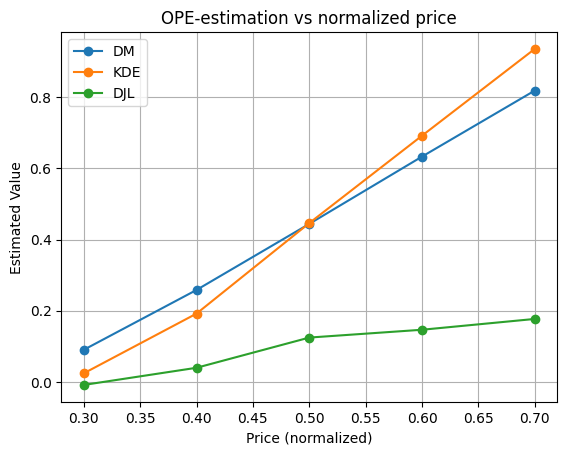

In [29]:
# ---------- 表とグラフ ----------
df_results = pd.DataFrame(results)
display(df_results)

plt.plot(df_results["Price"], df_results["DM"], label="DM", marker='o')
plt.plot(df_results["Price"], df_results["KDE"], label="KDE", marker='o')
plt.plot(df_results["Price"], df_results["DJL"], label="DJL", marker='o')
plt.title("OPE-estimation vs normalized price")
plt.xlabel("Price (normalized)")
plt.ylabel("Estimated Value")
plt.legend()
plt.grid()
plt.show()